# __Training and tuning the neural network__
- Dataset: Guarujá Municipality - São Paulo - Brazil
- Part 2/3

## Authorship:
        Caio Azevedo
        São Paulo University, February, 2024

## Main goals:

- Data processing for neural network application:
   - Elimination of extraneous features.
   - Normalization of the dataset.
   - ANN training, testing and validation dataset split.

- Training and evaluation of neural networks:
   - Custom neural network implementation.
   - Keras neural network implementation.
   
- Automation of hyperparameter setup for improved performance (criterion: accuracy).
   - Brute force for optimizing hyperparameters in the custom network.
   - Keras Tuning for optimizing Keras hyperparameters.
   
- Neural network performance assessment with and without 'less important features'.

- Compare custom ANN with Keras framework

## Coding

### Imported libraries

import datetime
start = datetime.datetime.now()

In [33]:
import Rede_Neural as rna
from Rede_Neural import NeuralNetwork
from Rede_Neural import Layer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns

from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from utils import plot

%matplotlib inline

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [35]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import statistics 

In [36]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow as tf

### Auxiliary functions

In [37]:
# Compute and display performance metrics 
def NetworkPerformance(y_real, y_prob):
    y_predict = (y_prob > 0.5)
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_real, y_predict)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_real, y_predict)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_real, y_predict)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_real, y_predict)
    print('F1 score: %f' % f1)
    # kappa
    kappa = cohen_kappa_score(y_real, y_predict)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(y_real, y_prob)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_real, y_predict)
    print(matrix)

In [38]:
# Compute and print ROC curve
def printAUROC(y_real,y_predict):
    ns_auc = roc_auc_score(y_real, y_predict)
    # summarize scores
    print('AUC ROC=%.4f' % (ns_auc))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_real, y_predict)
    random_probs = [0 for i in range(len(y_real))]
    p_fpr, p_tpr, _ = roc_curve(y_real, random_probs, pos_label=1)
    # plot the roc curve for the model
    plt.plot(p_fpr, p_tpr, linestyle='--', label='random', color='orange')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='ANN', color='blue')
    
    # axis labels
    pyplot.xlabel('false positive rate')
    pyplot.ylabel('true positive rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

In [39]:
# split data into training, validation and testing sets
def dataPreparation(dataSet):
    X = dataSet.drop('class',axis=1)
    y= dataSet['class']
    
    X = X.to_numpy()    #converts dataframe into array to be used at NN
    y = y.to_numpy()    #converts dataframe into array to be used at NN
    y = y.reshape(-1,1) #reorganiza o array em um array 1 x 1
    
    # split data into training, validation and testing sets
    seed = 7
    test_size = 0.30
    
    train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, shuffle=False)
    train_x, val_x, train_y, val_y   = train_test_split(train_x,train_y, test_size=test_size, shuffle=False)

    # define the scaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #scaler = MinMaxScaler() 
    # fit on the training dataset
    scaler.fit(train_x)
    # scale the training dataset
    train_x = scaler.transform(train_x)
    # scale the test dataset
    test_x = scaler.transform(test_x)
    # scale the test dataset
    val_x = scaler.transform(val_x)
    return train_x, test_x, val_x, train_y, test_y, val_y

In [40]:
# Plot a bubble chart with two features according to NN classification
def bubble_chart(data, col_2_buble_size, col_x, col_y):
    fig, ax = plt.subplots(figsize=(15,13))
    sizes = data[col_2_buble_size]*10
    scatter = ax.scatter(data[col_x], data[col_y], 
           c=(data['class']), cmap='rainbow', alpha=0.5,
           s=sizes, edgecolors='none')

    legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

    ax.title.set_text("{}{}".format(len(data.index), ' landslides samples')) 

    plt.show()

In [41]:
# Plot a bubble chart with two features according to NN classification and the actual values
def  bubble_double_chart(data, col_2_buble_size, col_x, col_y, accuracy):
    sizes = data[col_2_buble_size]*10

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))

    scatter = axes[0].scatter(data[col_x], data[col_y],
            c=(data['class']), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
    legend1 = axes[0].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

    scatter = axes[1].scatter(data[col_x], data[col_y],
            c=(data['score'] > 0.5), cmap='rainbow', alpha=0.3,
            s=sizes, edgecolors='none')
    legend1 = axes[1].legend(*scatter.legend_elements(),
                    loc="upper right", title="landslide")

    fig.tight_layout()
    text = 'predicted landslides ' + 'accuracy : {:.2f}%'.format(accuracy)
    axes[0].title.set_text('actual landslides')
    axes[1].title.set_text(text)

    plt.show()

In [42]:
def out_file_name(input_file_name):
    folder_bestANN = 'bestANN\\'
    
    if not os.path.exists(folder_bestANN):
      os.mkdir(folder_bestANN)
    
    out_f = os.path.splitext(input_file_name)[0]
    
    out_NN_custom = folder_bestANN + 'customNN_' + out_f + '.pkl'
    out_NN_keras  = folder_bestANN + 'kerasNN_' + out_f
    
    return out_NN_custom, out_NN_keras

### Select the dataset

- Switch one among the nine samples used in this study. The samples are configured according to the landslides' non-occurrence points' distance from the respective occurrence spot.

In [43]:
APP_PATH = os.getcwd()
#file = "guaruja_radius_50m_shuffled.csv"
#file = "guaruja_radius_100m_shuffled.csv"
#file = "guaruja_radius_150m_shuffled.csv"
#file = "guaruja_radius_200m_shuffled.csv"

#file = "guaruja_buffer_1km_shuffled.csv"
#file = "guaruja_buffer_2km_shuffled.csv"
#file = "guaruja_buffer_3km_shuffled.csv"
#file = "guaruja_buffer_4km_shuffled.csv"

file = "guaruja_random.csv"

dataset = pd.read_csv(os.path.join(APP_PATH, os.path.join("data", file))) 

# load the dataset
dataset_original = dataset.copy()
dataset.head(5)

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class
0,98,381913.2155,7358368.235,27.338095,0.002735,27.338095,120.943680,330.186584,65,90,0
1,152,375711.0000,7348857.000,5.155329,0.006004,24.772690,17.397917,113.472549,2,20,1
2,95,383008.5927,7357558.608,24.757074,0.000368,24.757074,207.428345,121.768433,65,90,0
3,106,371074.0000,7345111.000,6.688554,-0.010576,29.801399,15.330963,71.881042,2,20,1
4,82,375019.5230,7353140.890,0.221845,-0.000012,0.221845,2.162373,185.550385,2,70,0


In [44]:
dataset.shape

(200, 11)

In [45]:
#describing the dataframe to seek for distribution information
dataset.describe().round(2)

,FID,X,Y,twi,curvature,slope,elevation,aspect,lithology,land_use,class
count,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.00,200.0
mean,100.50,375351.60,7350229.58,14.42,0.03,23.94,64.32,209.79,32.56,75.80,0.5
std,57.88,4313.00,4368.70,13.62,0.41,11.79,56.08,103.92,31.56,26.72,0.5
min,1.00,365857.79,7341789.72,0.09,-0.59,0.09,0.23,0.04,2.00,20.00,0.0
25%,50.75,372179.26,7346972.48,4.29,-0.01,18.08,14.33,121.04,2.00,90.00,0.0
50%,100.50,375219.03,7349677.08,6.13,-0.00,25.33,54.48,202.74,2.00,90.00,0.0
75%,150.25,379116.73,7354032.25,26.33,0.00,30.77,94.71,316.40,65.00,90.00,1.0
max,200.00,383738.84,7359892.24,69.73,4.30,69.73,226.06,359.51,65.00,90.00,1.0


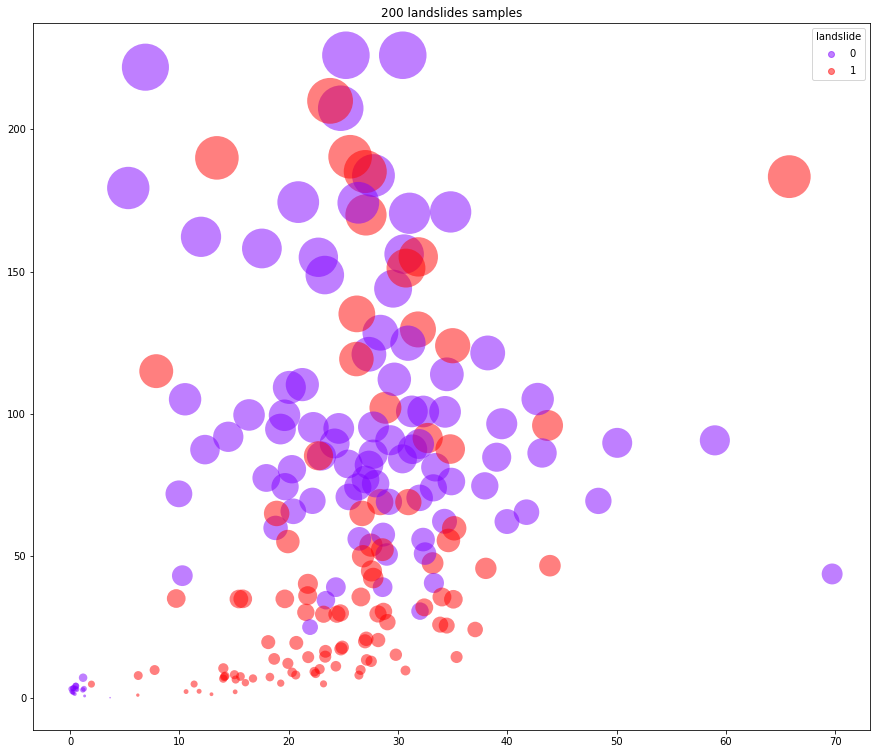

In [46]:
bubble_chart(dataset,"elevation","slope","elevation")

### Data Preparation
 - Based on the results of the feature importance analysis, all features were retained for training the ANN.
 - We addressed concerns about data leakage.

 - About most important features in best performed samples

  - Considering the random and 200m samples those with the best performance.
  - According to previous analyses we notice some features are less relevant than others.

     - In the scenario of a random sample, the pivotal features are identified as **twi**, **elevation**, and **land_use**. The overall accuracy, achieved with the optimal configuration using only these features, stands at approximately 98.50%, while utilizing all features yields a consistent 99% accuracy.

     - In instances where an event does not occur within a 200-meter radius of the sample occurrence, the most crucial features include **slope**, **twi**, **aspect**, and **curvature**. The overall accuracy, achieved with the best configuration using these features, is approximately 94.92%, compared to 93.91% when utilizing all features, a result that remains consistent.

After conducting numerous tests, it has been observed that the accuracy of the Artificial Neural Network (ANN) remains largely consistent, whether the most crucial features are included or not. Consequently, the decision has been made to retain all features in the model.

In [47]:
dataset = dataset[['slope','aspect','elevation','land_use','lithology','twi','curvature','class']]

#dataset = dataset.drop('slope',axis=1)
#dataset = dataset.drop('aspect',axis=1)

#dataset = dataset.drop('lithology',axis=1)
#dataset = dataset.drop('curvature',axis=1)

#dataset = dataset.drop('elevation',axis=1)
#dataset = dataset.drop('land_use',axis=1)

#dataset.head(5)

In [48]:
X_train, X_test, X_val, y_train, y_test, y_val = dataPreparation(dataset)

In [49]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

98 train examples
42 validation examples
60 test examples


In [50]:
print(X_train.min(axis=0), X_test.max(axis=0))

[-1. -1. -1. -1. -1. -1. -1.] [ 1.63025317  0.948116    1.03804377  1.          1.          1.35762042
 -0.98499636]


In [51]:
X = np.concatenate((X_train, X_val))
X = np.concatenate((X, X_test))

In [52]:
X.shape

(200, 7)

In [53]:
y = np.concatenate((y_train, y_val))
y = np.concatenate((y, y_test))

In [54]:
y.shape

(200, 1)

In [55]:
print(X.min(axis=0), X.max(axis=0))

[-1.         -1.00147197 -1.00818162 -1.         -1.         -1.
 -1.26211285] [1.78731424 1.00048694 1.03804377 1.         1.         1.78731424
 1.        ]


__Compute the number of input and output features__

In [56]:
input_dim, output_dim = X_train.shape[1], y_train.shape[1]

### Custom neural network training

#### Hyperparameters tunning
- Brute force method
- Custom implementation for classes and functions

In [57]:
class hyperparametros: 
    def __init__(self, acuracia, camadas,neuronios,learning_rate,batch_size,dropout): 
        self.acuracia = acuracia 
        self.camadas = camadas
        self.neuronios = neuronios 
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.dropout = dropout

In [58]:
class ANN_accuracy: 
    def __init__(self, acuracia, _neuralNetwork): 
        self.acuracia = acuracia 
        self.ann = _neuralNetwork

In [59]:
#patience = early stopping
def setBestNeuralNetwork(hidden_layers,neurons, num_learning_rate, droput, input_dim, output_dim):
    nn = NeuralNetwork(cost_func = rna.binary_cross_entropy, learning_rate = num_learning_rate, momentum=0.1, patience=50) 

    #input layer
    nn.layers.append(Layer(input_dim=input_dim, output_dim=neurons,activation= rna.relu, weights_initializer=rna.glorot_normal))

    for num_hidden_layers in range(1,hidden_layers+1,1):
        nn.layers.append(Layer(input_dim=neurons, output_dim=neurons,activation=rna.relu,dropout_prob = droput,weights_initializer=rna.glorot_normal,biases_initializer=rna.glorot_normal))

    #output layer
    nn.layers.append(Layer(input_dim=neurons, output_dim=output_dim,activation=rna.sigmoid,weights_initializer=rna.glorot_normal))  

    return nn

In [60]:
# (batch_size) Implements the mini-batch that accelerates the training time, requires a mini-batch initialization method. 
#It is ideal for the batch size to be a multiple of the training dataset size, which is 128 here.
neurons = [7,8,12] 
hidden_layers = [1,2,3]
learning_rate = [0.001,0.005,0.01]
batch_size = [0,4,8] 
dropout_rate = [0,0.1]
best_of_best_ANN = []
best_of_best_hyper = []

In [61]:
lst_hyperP = []
lst_ANN = []
for num_hidden_layers in hidden_layers:
    for num_neurons_layers in neurons:
        for num_learning_rate in learning_rate:
            for num_batch_size in batch_size:
                for prob_dropout in dropout_rate:
                    nn = setBestNeuralNetwork(num_hidden_layers,num_neurons_layers, num_learning_rate, prob_dropout, input_dim, output_dim)
                    
                    nn.fit(X_train, y_train, epochs=40000,batch_gen= rna.batch_shuffle, batch_size=num_batch_size, verbose=3000)
                
                    y_pred = nn.predict(X_val)
                    accu = 100*accuracy_score(y_val, y_pred > 0.5)
                    #accu = 100*roc_auc_score(y_val, y_pred > 0.5)
                    lst_hyperP.append(hyperparametros(accu,num_hidden_layers,num_neurons_layers,num_learning_rate,num_batch_size,prob_dropout) )
                    lst_ANN.append(ANN_accuracy(accu,nn))
                    print('To {} neurons, {} layer(s),  {} learning rate, {} batch size, {} dropout rate, we have: \033[1m Accuracy: {:.2f}% \033[0m'.format(num_neurons_layers,num_hidden_layers,num_learning_rate,num_batch_size,prob_dropout, accu))

epoch:    0/40000 loss_train: 0.99277899 + 0.00000000 = 0.99277899 loss_val = 0.99277899
epoch: 3000/40000 loss_train: 0.52710794 + 0.00000000 = 0.52710794 loss_val = 0.52710794
epoch: 6000/40000 loss_train: 0.34626030 + 0.00000000 = 0.34626030 loss_val = 0.34626030
epoch: 9000/40000 loss_train: 0.21120853 + 0.00000000 = 0.21120853 loss_val = 0.21120853
epoch: 12000/40000 loss_train: 0.13161062 + 0.00000000 = 0.13161062 loss_val = 0.13161062
epoch: 15000/40000 loss_train: 0.09435708 + 0.00000000 = 0.09435708 loss_val = 0.09435708
epoch: 18000/40000 loss_train: 0.07556715 + 0.00000000 = 0.07556715 loss_val = 0.07556715
epoch: 21000/40000 loss_train: 0.06429519 + 0.00000000 = 0.06429519 loss_val = 0.06429519
epoch: 24000/40000 loss_train: 0.05669215 + 0.00000000 = 0.05669215 loss_val = 0.05669215
epoch: 27000/40000 loss_train: 0.05112515 + 0.00000000 = 0.05112515 loss_val = 0.05112515
epoch: 30000/40000 loss_train: 0.04679289 + 0.00000000 = 0.04679289 loss_val = 0.04679289
epoch: 33000/4

c:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
c:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
c:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 7 neurons, 1 layer(s),  0.005 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.71313144 + 0.00000000 = 0.71313144 loss_val = 0.71313144
epoch: 3000/40000 loss_train: 0.27211283 + 0.00000000 = 0.27211283 loss_val = 0.27211283
epoch: 6000/40000 loss_train: 0.19392910 + 0.00000000 = 0.19392910 loss_val = 0.19392910
epoch: 9000/40000 loss_train: 0.10098394 + 0.00000000 = 0.10098394 loss_val = 0.10098394
epoch: 12000/40000 loss_train: 0.06875589 + 0.00000000 = 0.06875589 loss_val = 0.06875589
epoch: 15000/40000 loss_train: 0.05577760 + 0.00000000 = 0.05577760 loss_val = 0.05577760
To 7 neurons, 1 layer(s),  0.005 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.65496249 + 0.00000000 = 0.65496249 loss_val = 0.65496249
epoch: 3000/40000 loss_train: 0.23344733 + 0.00000000 = 0.23344733 loss_val = 0.23344733
epoch: 6000/40000 loss_train: 0.14289941 + 0.00000000 = 0.14289941 loss

c:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
c:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
c:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 7 neurons, 1 layer(s),  0.01 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.79431504 + 0.00000000 = 0.79431504 loss_val = 0.79431504
epoch: 3000/40000 loss_train: 0.42534910 + 0.00000000 = 0.42534910 loss_val = 0.42534910
epoch: 6000/40000 loss_train: 0.12282848 + 0.00000000 = 0.12282848 loss_val = 0.12282848
epoch: 9000/40000 loss_train: 0.08959552 + 0.00000000 = 0.08959552 loss_val = 0.08959552
To 7 neurons, 1 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.91725499 + 0.00000000 = 0.91725499 loss_val = 0.91725499
epoch: 3000/40000 loss_train: 0.09456689 + 0.00000000 = 0.09456689 loss_val = 0.09456689
epoch: 6000/40000 loss_train: 0.07963057 + 0.00000000 = 0.07963057 loss_val = 0.07963057
epoch: 9000/40000 loss_train: 0.07386469 + 0.00000000 = 0.07386469 loss_val = 0.07386469
epoch: 12000/40000 loss_train: 0.06844444 + 0.00000000 = 0.06844444 loss_va

c:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
c:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
c:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


epoch: 3000/40000 loss_train: 0.05075069 + 0.00000000 = 0.05075069 loss_val = 0.05075069
epoch: 6000/40000 loss_train: 0.02438044 + 0.00000000 = 0.02438044 loss_val = 0.02438044
epoch: 9000/40000 loss_train: 0.01516822 + 0.00000000 = 0.01516822 loss_val = 0.01516822
epoch: 12000/40000 loss_train: 0.01053634 + 0.00000000 = 0.01053634 loss_val = 0.01053634
To 8 neurons, 1 layer(s),  0.01 learning rate, 8 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 0.82294464 + 0.00000000 = 0.82294464 loss_val = 0.82294464
epoch: 3000/40000 loss_train: 0.36248839 + 0.00000000 = 0.36248839 loss_val = 0.36248839
epoch: 6000/40000 loss_train: 0.20611392 + 0.00000000 = 0.20611392 loss_val = 0.20611392
epoch: 9000/40000 loss_train: 0.13894345 + 0.00000000 = 0.13894345 loss_val = 0.13894345
epoch: 12000/40000 loss_train: 0.10830151 + 0.00000000 = 0.10830151 loss_val = 0.10830151
epoch: 15000/40000 loss_train: 0.09163637 + 0.00000000 = 0.09163637 loss_val = 0.09163637


c:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
c:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
c:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 12 neurons, 1 layer(s),  0.01 learning rate, 0 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.83311889 + 0.00000000 = 0.83311889 loss_val = 0.83311889
epoch: 3000/40000 loss_train: 0.06580911 + 0.00000000 = 0.06580911 loss_val = 0.06580911
epoch: 6000/40000 loss_train: 0.03580638 + 0.00000000 = 0.03580638 loss_val = 0.03580638
epoch: 9000/40000 loss_train: 0.02442369 + 0.00000000 = 0.02442369 loss_val = 0.02442369
epoch: 12000/40000 loss_train: 0.01738299 + 0.00000000 = 0.01738299 loss_val = 0.01738299
epoch: 15000/40000 loss_train: 0.01262761 + 0.00000000 = 0.01262761 loss_val = 0.01262761
epoch: 18000/40000 loss_train: 0.00952854 + 0.00000000 = 0.00952854 loss_val = 0.00952854
To 12 neurons, 1 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.69615976 + 0.00000000 = 0.69615976 loss_val = 0.69615976
epoch: 3000/40000 loss_train: 0.07912949 + 0.00000000 = 0.07912949 los

c:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
c:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
c:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 7 neurons, 2 layer(s),  0.01 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.87785852 + 0.00000000 = 0.87785852 loss_val = 0.87785852
epoch: 3000/40000 loss_train: 0.12819013 + 0.00000000 = 0.12819013 loss_val = 0.12819013
To 7 neurons, 2 layer(s),  0.01 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 100.00% 
epoch:    0/40000 loss_train: 0.93850383 + 0.00000000 = 0.93850383 loss_val = 0.93850383
epoch: 3000/40000 loss_train: 0.05405262 + 0.00000000 = 0.05405262 loss_val = 0.05405262
epoch: 6000/40000 loss_train: 0.03148399 + 0.00000000 = 0.03148399 loss_val = 0.03148399
epoch: 9000/40000 loss_train: 0.01656466 + 0.00000000 = 0.01656466 loss_val = 0.01656466
epoch: 12000/40000 loss_train: 0.00848971 + 0.00000000 = 0.00848971 loss_val = 0.00848971
epoch: 15000/40000 loss_train: 0.00473984 + 0.00000000 = 0.00473984 loss_val = 0.00473984
epoch: 18000/40000 loss_train: 0.00294488 + 0.00000000 = 0.00294488 loss_

c:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 12 neurons, 2 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.97171739 + 0.00000000 = 0.97171739 loss_val = 0.97171739
epoch: 3000/40000 loss_train: 0.04985573 + 0.00000000 = 0.04985573 loss_val = 0.04985573
epoch: 6000/40000 loss_train: 0.02845537 + 0.00000000 = 0.02845537 loss_val = 0.02845537
epoch: 9000/40000 loss_train: 0.01499004 + 0.00000000 = 0.01499004 loss_val = 0.01499004
epoch: 12000/40000 loss_train: 0.00813690 + 0.00000000 = 0.00813690 loss_val = 0.00813690
epoch: 15000/40000 loss_train: 0.00499769 + 0.00000000 = 0.00499769 loss_val = 0.00499769
epoch: 18000/40000 loss_train: 0.00334879 + 0.00000000 = 0.00334879 loss_val = 0.00334879
epoch: 21000/40000 loss_train: 0.00235487 + 0.00000000 = 0.00235487 loss_val = 0.00235487
epoch: 24000/40000 loss_train: 0.00178352 + 0.00000000 = 0.00178352 loss_val = 0.00178352
epoch: 27000/40000 loss_train: 0.00140049 + 0.00000000 = 0.00140049 loss_val = 0.00140

c:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: divide by zero encountered in log
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
c:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:137: RuntimeWarning: invalid value encountered in multiply
  return -np.mean(y*np.log(y_pred) +  (1 - y)*np.log(1 - y_pred))
c:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 12 neurons, 2 layer(s),  0.01 learning rate, 4 batch size, 0 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.71581096 + 0.00000000 = 0.71581096 loss_val = 0.71581096
epoch: 3000/40000 loss_train: 0.03449249 + 0.00000000 = 0.03449249 loss_val = 0.03449249
To 12 neurons, 2 layer(s),  0.01 learning rate, 4 batch size, 0.1 dropout rate, we have:  Accuracy: 97.62% 
epoch:    0/40000 loss_train: 1.17930797 + 0.00000000 = 1.17930797 loss_val = 1.17930797
epoch: 3000/40000 loss_train: 0.05304041 + 0.00000000 = 0.05304041 loss_val = 0.05304041
epoch: 6000/40000 loss_train: 0.03188472 + 0.00000000 = 0.03188472 loss_val = 0.03188472
epoch: 9000/40000 loss_train: 0.01397628 + 0.00000000 = 0.01397628 loss_val = 0.01397628
epoch: 12000/40000 loss_train: 0.00583047 + 0.00000000 = 0.00583047 loss_val = 0.00583047
epoch: 15000/40000 loss_train: 0.00293955 + 0.00000000 = 0.00293955 loss_val = 0.00293955
epoch: 18000/40000 loss_train: 0.00186938 + 0.00000000 = 0.00186938 loss

c:\Caio\DevProjects\Python\academico\doutorado\tese\paper_susceptibility_map\Rede_Neural.py:136: RuntimeWarning: invalid value encountered in true_divide
  return -(y - y_pred) / (y_pred * (1 - y_pred) * y.shape[0])


To 8 neurons, 3 layer(s),  0.01 learning rate, 0 batch size, 0.1 dropout rate, we have:  Accuracy: 57.14% 
epoch:    0/40000 loss_train: 0.83417491 + 0.00000000 = 0.83417491 loss_val = 0.83417491
epoch: 3000/40000 loss_train: 0.03651171 + 0.00000000 = 0.03651171 loss_val = 0.03651171
epoch: 6000/40000 loss_train: 0.01164549 + 0.00000000 = 0.01164549 loss_val = 0.01164549
epoch: 9000/40000 loss_train: 0.00354662 + 0.00000000 = 0.00354662 loss_val = 0.00354662
epoch: 12000/40000 loss_train: 0.00158304 + 0.00000000 = 0.00158304 loss_val = 0.00158304
epoch: 15000/40000 loss_train: 0.00091860 + 0.00000000 = 0.00091860 loss_val = 0.00091860
epoch: 18000/40000 loss_train: 0.00061552 + 0.00000000 = 0.00061552 loss_val = 0.00061552
epoch: 21000/40000 loss_train: 0.00045014 + 0.00000000 = 0.00045014 loss_val = 0.00045014
epoch: 24000/40000 loss_train: 0.00034851 + 0.00000000 = 0.00034851 loss_val = 0.00034851
epoch: 27000/40000 loss_train: 0.00028100 + 0.00000000 = 0.00028100 loss_val = 0.000281

In [62]:
best_hyper = max(lst_hyperP, key=lambda hyper: hyper.acuracia)
best_of_best_hyper.append(hyperparametros(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout) )
print('{:.2f}% was the best\033[1m accuracy\033[0m, having {} layer(s),{} neurons, {} of learning rate and {} of batch size as hyperparameters!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size))

100.00% was the best accuracy, having 1 layer(s),7 neurons, 0.001 of learning rate and 0 of batch size as hyperparameters!


In [63]:
best_ann = max(lst_ANN, key=lambda hyper: hyper.acuracia)
best_of_best_ANN.append(ANN_accuracy(best_ann.acuracia,best_ann.ann))
print('{:.2f}% was the best\033[1m accuracy\033[0m, with ANN {} '.format(best_ann.acuracia,best_ann.ann))

100.00% was the best accuracy, with ANN <Rede_Neural.NeuralNetwork object at 0x0000015A4FDFD0D0> 


In [64]:
print('{} was the number of anns trained '.format(len(lst_ANN)))
lst_hyperP = []
lst_ANN = []

162 was the number of anns trained 


#### Assessment

In [65]:
best_of_best_ANN_Test = []
for best_RNA in best_of_best_ANN: 
  bestNN = best_RNA.ann
  yhat_probs = bestNN.predict(X_test)
  yhat_classes = (yhat_probs > 0.5)
  accu = 100*accuracy_score(y_test,yhat_classes)
  accMedia = (accu + best_RNA.acuracia) / 2
  print('{:.2f}% accu_test - {:.2f}% as the best\033[1m accurancy\033[0m, {:.2f} average acc {} ANN!'.format(accu,best_RNA.acuracia,accMedia,best_RNA.ann))
  accu = accMedia  
  best_of_best_ANN_Test.append(ANN_accuracy(accu,bestNN))

98.33% accu_test - 100.00% as the best accurancy, 99.17 average acc <Rede_Neural.NeuralNetwork object at 0x0000015A4FDFD0D0> ANN!


In [66]:
for best_hyper in best_of_best_hyper: 
  print('{:.2f}% as the best\033[1m accurancy\033[0m, configured with {} layers,{} neurons, {} of learning rate, {} batch size and {} dropout rate!'.format(best_hyper.acuracia,best_hyper.camadas,best_hyper.neuronios, best_hyper.learning_rate,best_hyper.batch_size,best_hyper.dropout))

100.00% as the best accurancy, configured with 1 layers,7 neurons, 0.001 of learning rate, 0 batch size and 0 dropout rate!


In [67]:
bestNN_Test = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN_Test = bestNN_Test.ann

In [68]:
yhat_probs = bestNN_Test.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, test sample accurancy !'.format(accu))

98.33%, test sample accurancy !


**Second approach** - Configure another ANN with the parameters obtained from the brute-force optimization.

In [69]:
bestNN = max(best_of_best_ANN_Test, key=lambda hyper: hyper.acuracia)
bestNN = bestNN.ann

In [70]:
bestHyper = max(best_of_best_hyper, key=lambda hyper: hyper.acuracia)
print('{:.2f}% as the best\033[1m accurancy\033[0m, configured with {} layers, {} of learning rate, {} batch size and {} dropout rate!'.format(bestHyper.acuracia,bestHyper.camadas, bestHyper.learning_rate,bestHyper.batch_size,bestHyper.dropout))

100.00% as the best accurancy, configured with 1 layers, 0.001 of learning rate, 0 batch size and 0 dropout rate!


In [71]:
yhat_probs = bestNN.predict(X_test)
yhat_classes = (yhat_probs > 0.5)
accu = 100*accuracy_score(y_test,yhat_classes)
print('{:.2f}%, test sample accurancy !'.format(accu))

98.33%, test sample accurancy !


#### Saving the best ANN architeture
 - Given the best set of hyperparameters, trained ANN is saved if its accuracy with test sample surpass 85%.

In [72]:
NN_custom, NN_keras = out_file_name(file)

In [73]:
if accu >= 85:
    print('{:.2f}%, excellent accuracy for test sample, ANN saved in \033[1m{}\033[0m!'.format(accu,NN_custom))
    bestNN.save(NN_custom)
else:
    print('Accuracy: {:.2f}% testing sample accuracy under .85!'.format(accu))

98.33%, excellent accuracy for test sample, ANN saved in bestANN\customNN_guaruja_random.pkl!


#### Overall results

In [74]:
y_pred = bestNN.predict(X_train)
print('\033[1mTraining sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y_train, y_pred > 0.5)))
NetworkPerformance(y_train, y_pred)

Training sample accuracy: 98.98%
Accuracy: 0.989796
Precision: 1.000000
Recall: 0.980769
F1 score: 0.990291
Cohens kappa: 0.979541
ROC AUC: 1.000000
[[46  0]
 [ 1 51]]


In [75]:
y_pred = bestNN.predict(X_val)
print('\033[1mValidation sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y_val, y_pred > 0.5)))
NetworkPerformance(y_val, y_pred)

Validation sample accuracy: 100.00%
Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000
ROC AUC: 1.000000
[[24  0]
 [ 0 18]]


In [76]:
y_pred = bestNN.predict(X_test)
print('\033[1mTest sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y_test, y_pred > 0.5)))
NetworkPerformance(y_test, y_pred)

Test sample accuracy: 98.33%
Accuracy: 0.983333
Precision: 1.000000
Recall: 0.965517
F1 score: 0.982456
Cohens kappa: 0.966592
ROC AUC: 0.989989
[[31  0]
 [ 1 28]]


In [77]:
y_pred = bestNN.predict(X)
print('\033[1mOverall sample accuracy: {:.2f}%\033[0m'.format(100*accuracy_score(y, y_pred > 0.5)))
NetworkPerformance(y, y_pred)

Overall sample accuracy: 99.00%
Accuracy: 0.990000
Precision: 1.000000
Recall: 0.979798
F1 score: 0.989796
Cohens kappa: 0.979994
ROC AUC: 0.997700
[[101   0]
 [  2  97]]


AUC ROC=0.9977


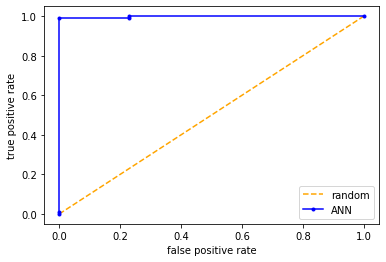

In [78]:
printAUROC(y,y_pred)

In [79]:
cf_matrix = confusion_matrix(y,(y_pred > 0.5))

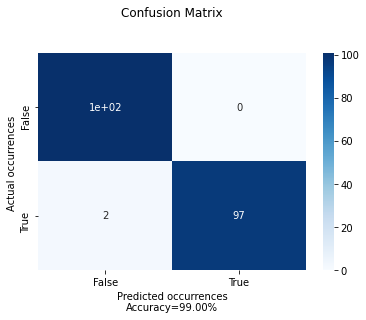

In [80]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('Predicted occurrences\nAccuracy={:0.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
ax.set_ylabel('Actual occurrences ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [81]:
output_dataset = None
output_dataset = dataset_original
output_dataset['score'] = y_pred

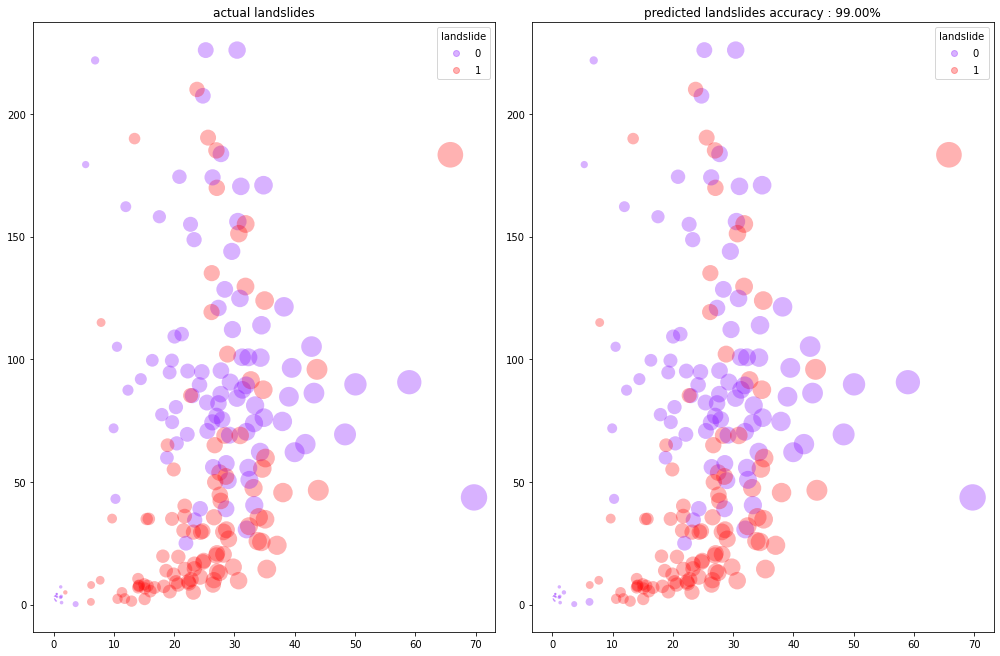

In [82]:
bubble_double_chart(output_dataset,"slope","slope","elevation",100*accuracy_score(y, y_pred > 0.5))

#### RepeatedStratifiedKfold Assessment 

In [83]:
print(X.min(axis=0), X.max(axis=0))

[-1.         -1.00147197 -1.00818162 -1.         -1.         -1.
 -1.26211285] [1.78731424 1.00048694 1.03804377 1.         1.         1.78731424
 1.        ]


In [84]:
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Number of Splits_stratified of X: ',rskf.get_n_splits(X, y),'\n')

# Print_stratifiedting the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified, X_test_stratified = X[train_index], X[test_index]
    y_train_stratified, y_test_stratified = y[train_index], y[test_index]
    print(X_train_stratified.shape, y_train_stratified.shape)
    
    yhat_probs = bestNN.predict(X_test_stratified)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified, yhat_probs > 0.5))

Number of Splits_stratified of X:  10 

(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)
(160, 7) (160, 1)


In [85]:
print('List of obtained accuracies:', lst_accu_stratified)
print('\nMaximum accuracy:',
      max(lst_accu_stratified), '%')
print('\nMinimum accuracy:',
      min(lst_accu_stratified), '%')
print('\nAvarage accuracy:',
      statistics.mean(lst_accu_stratified), '%')
print('\nStandard deviation:', statistics.stdev(lst_accu_stratified))

List of obtained accuracies: [97.5, 100.0, 97.5, 100.0, 100.0, 100.0, 97.5, 100.0, 97.5, 100.0]

Maximum accuracy: 100.0 %

Minimum accuracy: 97.5 %

Avarage accuracy: 99.0 %

Standard deviation: 1.2909944487358056


In [86]:
dataset

,slope,aspect,elevation,land_use,lithology,twi,curvature,class
0,27.338095,330.186584,120.943680,90,65,27.338095,0.002735,0
1,24.772690,113.472549,17.397917,20,2,5.155329,0.006004,1
2,24.757074,121.768433,207.428345,90,65,24.757074,0.000368,0
3,29.801399,71.881042,15.330963,20,2,6.688554,-0.010576,1
4,0.221845,185.550385,2.162373,70,2,0.221845,-0.000012,0
...,...,...,...,...,...,...,...,...
195,65.807915,335.578705,183.386307,90,65,3.111852,0.009217,1
196,34.884327,335.742798,76.214539,90,2,34.884327,-0.003104,0
197,16.367725,167.967239,99.617256,90,2,16.367725,0.009234,0
198,30.434063,155.315613,226.055237,90,65,30.434063,0.000543,0


ROC AUC=0.998


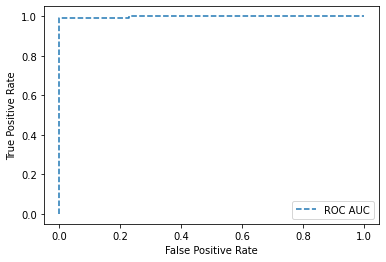

In [87]:
from matplotlib import pyplot
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [88]:
y_pred = bestNN.predict(X)
yhat_classes = (y_pred > 0.5)
print('Acurácia: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))
output_dataset = None
output_dataset = dataset_original
output_dataset['score'] = y_pred

Acurácia: 99.00%


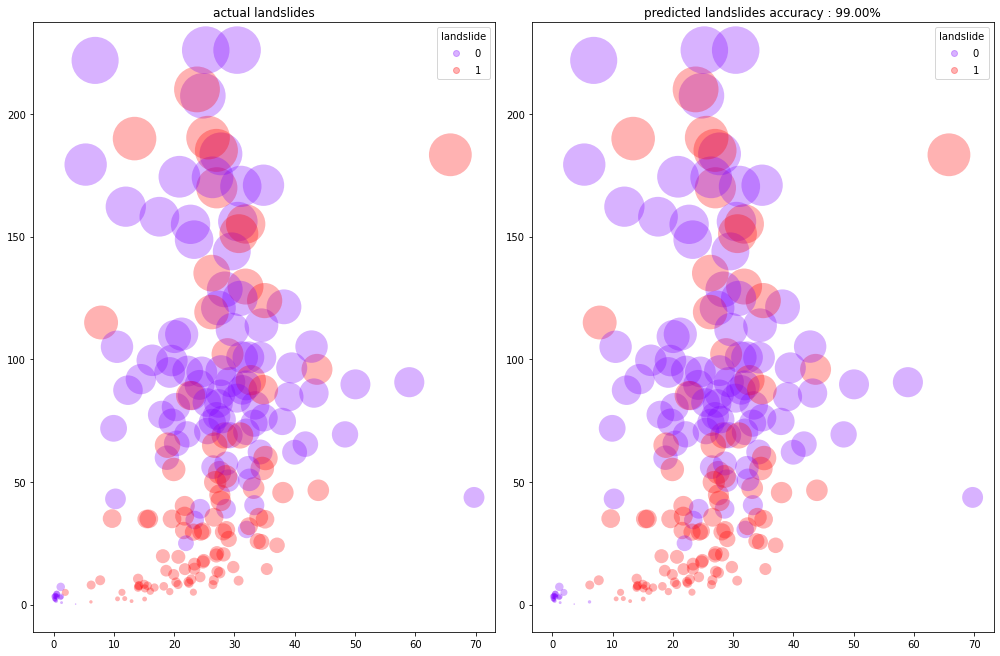

In [89]:
bubble_double_chart(output_dataset,"elevation","slope","elevation",100*accuracy_score(y, y_pred > 0.5))

In [90]:
end = datetime.datetime.now()
print(end-start)
#quit()

0:51:29.113369


### Keras Framework
__Clasification problem, see best practices:__
- Hyperparameters tuning
- Baseline to custom implementation 

In [91]:
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

98 train examples
42 validation examples
60 test examples


In [92]:
hypermodel = keras.Sequential()
hypermodel.add(Dense(24, activation='relu', input_dim=input_dim))

hypermodel.add(Dense(24, activation='relu'))
hypermodel.add(Dropout(0.43719886068153724))

hypermodel.add(Dense(1, activation='sigmoid'))
learning_rate= 0.01
myOptimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
hypermodel.compile(optimizer=myOptimizer, loss="binary_crossentropy", metrics=['accuracy'])

In [93]:
#model.fit(X_train, y_train, epochs=100, batch_size=5)
history           = hypermodel.fit(X_train, y_train, epochs=500, batch_size=5)
val_acc_per_epoch = history.history['accuracy']
best_epoch        = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

Epoch 1/500
20/20 [==============================] - 1s 822us/step - loss: 0.6839 - accuracy: 0.5306
Epoch 2/500
20/20 [==============================] - 0s 822us/step - loss: 0.6763 - accuracy: 0.5918
Epoch 3/500
20/20 [==============================] - 0s 2ms/step - loss: 0.6819 - accuracy: 0.5102
Epoch 4/500
20/20 [==============================] - 0s 2ms/step - loss: 0.6385 - accuracy: 0.6531
Epoch 5/500
20/20 [==============================] - 0s 822us/step - loss: 0.6425 - accuracy: 0.6327
Epoch 6/500
20/20 [==============================] - 0s 822us/step - loss: 0.6521 - accuracy: 0.6020
Epoch 7/500
20/20 [==============================] - 0s 2ms/step - loss: 0.6409 - accuracy: 0.6837
Epoch 8/500
20/20 [==============================] - 0s 2ms/step - loss: 0.6256 - accuracy: 0.7245
Epoch 9/500
20/20 [==============================] - 0s 2ms/step - loss: 0.6259 - accuracy: 0.7143
Epoch 10/500
20/20 [==============================] - 0s 2ms/step - loss: 0.6225 - accuracy: 0.6939
E

In [94]:
print('Best epoch: %d' % (best_epoch,))

Best epoch: 104


In [95]:
# keras assessment
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

2/2 [==============================] - 0s 0s/step - loss: 0.1184 - accuracy: 0.9667
Accuracy: 96.67


In [96]:
# Retrain the model
history = hypermodel.fit(X_train, y_train, epochs=best_epoch)

Epoch 1/104
4/4 [==============================] - 0s 3ms/step - loss: 0.0178 - accuracy: 1.0000
Epoch 2/104
4/4 [==============================] - 0s 2ms/step - loss: 0.0298 - accuracy: 0.9898
Epoch 3/104
4/4 [==============================] - 0s 3ms/step - loss: 0.0143 - accuracy: 1.0000
Epoch 4/104
4/4 [==============================] - 0s 0s/step - loss: 0.0268 - accuracy: 1.0000
Epoch 5/104
4/4 [==============================] - 0s 2ms/step - loss: 0.0358 - accuracy: 1.0000
Epoch 6/104
4/4 [==============================] - 0s 2ms/step - loss: 0.0292 - accuracy: 0.9898
Epoch 7/104
4/4 [==============================] - 0s 3ms/step - loss: 0.0253 - accuracy: 1.0000
Epoch 8/104
4/4 [==============================] - 0s 0s/step - loss: 0.0261 - accuracy: 0.9898
Epoch 9/104
4/4 [==============================] - 0s 5ms/step - loss: 0.0243 - accuracy: 1.0000
Epoch 10/104
4/4 [==============================] - 0s 5ms/step - loss: 0.0253 - accuracy: 1.0000
Epoch 11/104
4/4 [=============

#### Assessment

In [97]:
# Keras assessment
_, accuracy = hypermodel.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

2/2 [==============================] - 0s 4ms/step - loss: 0.1204 - accuracy: 0.9667
Accuracy: 96.67


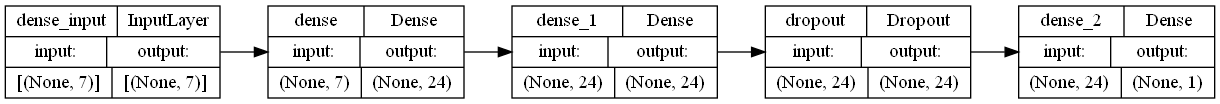

In [98]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(hypermodel, show_shapes=True, rankdir="LR")

#### Saving the best ANN architeture
 - Given the best set of hyperparameters, trained ANN is saved if its accuracy with test sample surpass 85%.

In [99]:
if accuracy >= .85:
    print('{:.2f}%, excellent accuracy for test sample, ANN saved!'.format(accuracy*100))
    hypermodel.save(NN_keras) 
else:
    print('Accuracy: {:.2f}% testing sample accuracy under .85!'.format(accu))

96.67%, excellent accuracy for test sample, ANN saved!
INFO:tensorflow:Assets written to: bestANN\kerasNN_guaruja_random\assets


#### RepeatedStratifiedKFold Assessment

In [100]:
lst_accu_stratified = []

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2,random_state=36851234)

print ('Splits numbers of X: ',rskf.get_n_splits(X, y),'\n')

# Printing the Train & Test Indices of splits
for train_index, test_index in rskf.split(X, y): 
    #print ("TRAIN:", train_index, "TEST:", test_index)
    X_train_stratified_keras, X_test_stratified_keras = X[train_index], X[test_index]
    y_train_stratified_keras, y_test_stratified_keras = y[train_index], y[test_index]
    #print(X_train_stratified_keras.shape, y_train_stratified_keras.shape)
    
    yhat_probs = hypermodel.predict(X_test_stratified_keras)
    lst_accu_stratified.append(100*accuracy_score(y_test_stratified_keras, yhat_probs > 0.5))

Splits numbers of X:  10 

2/2 [==============================] - 0s 0s/step


In [101]:
print('List of obtained accuracies:', lst_accu_stratified)
print('\nMaximum accuracy:',
      max(lst_accu_stratified), '%')
print('\nMinimum accuracy:',
      min(lst_accu_stratified), '%')
print('\nAvarage accuracy:',
      statistics.mean(lst_accu_stratified), '%')
print('\nStandard deviation:', statistics.stdev(lst_accu_stratified))

List of obtained accuracies: [100.0, 100.0, 95.0, 100.0, 100.0, 100.0, 97.5, 97.5, 100.0, 100.0]

Maximum accuracy: 100.0 %

Minimum accuracy: 95.0 %

Avarage accuracy: 99.0 %

Standard deviation: 1.7480147469502525


In [102]:
y_pred = hypermodel.predict(X_test)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_test, y_pred > 0.5)))

2/2 [==============================] - 0s 2ms/step
Accuracy: 96.67%


In [103]:
y_pred = hypermodel.predict(X_train)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_train, y_pred > 0.5)))

4/4 [==============================] - 0s 997us/step
Accuracy: 100.00%


In [104]:
y_pred = hypermodel.predict(X_val)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y_val, y_pred > 0.5)))

2/2 [==============================] - 0s 2ms/step
Accuracy: 100.00%


In [105]:
y_pred = hypermodel.predict(X)
print('Accuracy: {:.2f}%'.format(100*accuracy_score(y, y_pred > 0.5)))

7/7 [==============================] - 0s 1ms/step
Accuracy: 99.00%


In [106]:
NetworkPerformance(y, y_pred)

Accuracy: 0.990000
Precision: 0.989899
Recall: 0.989899
F1 score: 0.989899
Cohens kappa: 0.979998
ROC AUC: 0.997200
[[100   1]
 [  1  98]]


ROC AUC=0.997


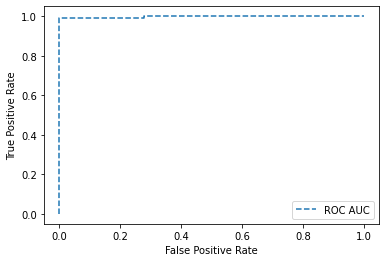

In [107]:
ns_auc = roc_auc_score(y, y_pred)
# summarize scores
print('ROC AUC=%.3f' % (ns_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC AUC')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

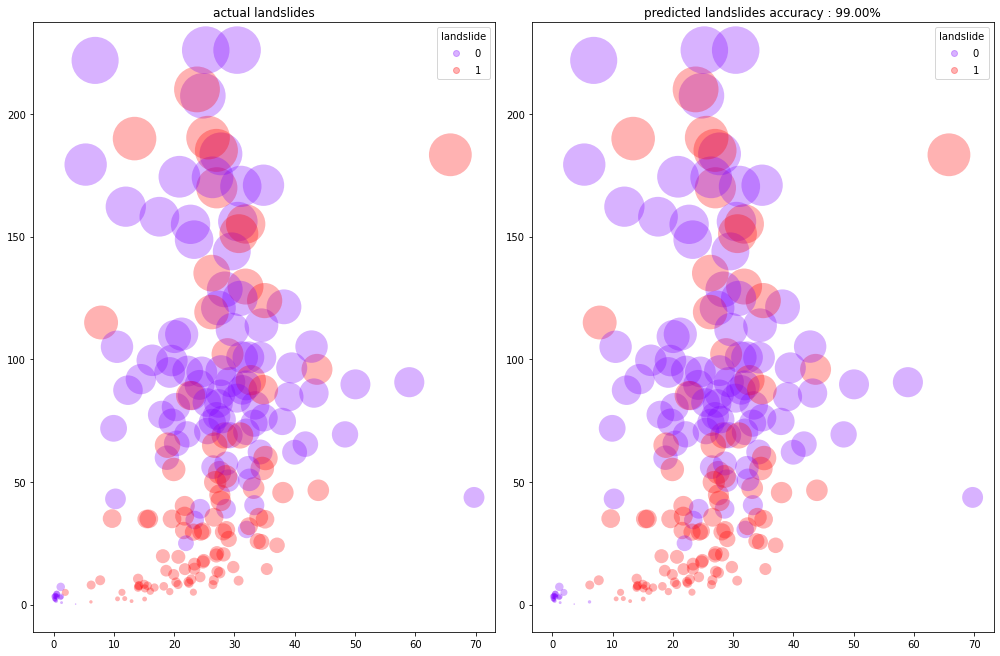

In [108]:
bubble_double_chart(output_dataset,"elevation","slope","elevation",100*accuracy_score(y, y_pred > 0.5))

In [109]:
end = datetime.datetime.now()
print(end-start)

0:51:52.344814


## References
- ref.1: https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
- ref.2: https://www.tensorflow.org/tutorials/structured_data/feature_columns
- ref.3: https://realpython.com/train-test-split-python-data/
- ref.4: https://machinelearningmastery.com/data-preparation-without-data-leakage/
- ref.5: https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742
- ref.6: https://analyticsindiamag.com/what-is-data-leakage-in-ml-why-should-you-be-concerned/
- ref.7: https://www.section.io/engineering-education/data-leakage/
- ref.8: https://medium.com/analytics-vidhya/overfitting-vs-data-leakage-in-machine-learning-ec59baa603e1
- ref.9: https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
- ref. 10: https://medium.com/mdr-inc/from-sgd-to-adam-c9fce513c4bb
- ref. 11: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
- ref. 12: http://karpathy.github.io/2019/04/25/recipe/
- ref. 13: https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc
- ref. 14: https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/
- ref. 15: https://medium.com/@venkatasujit272/overview-of-cross-validation-3785d5414ece
- ref. 16: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- ref. 17: https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
- ref. 18: https://machinelearningmastery.com/data-preparation-without-data-leakage/